# Predicting Flu Vaccine Compliance

## Overview

The CDC has provided the National 2009 H1N1 Flu Survey. They want to pull out the **most useful features** from this model in order to later create **a new survey** on compliance with COVID-19 vaccines. 

### Buisness Problem

Creating a model to pull out features that best predict who will get the seasonal flu vaccine. 

### Dataset Size 

The initial dataset was 26,707 rows with 36 columns. After initial data cleaning there were 27 columns. 

### Limitations of the Dataset

The data was collected via telephone surveys, a commonly used polling method which is not representative or random (as people choose to respond or not when they are called). Additionally, new surveys and models may need to take into account the anti-vaccine movement (article [here](https://pubmed.ncbi.nlm.nih.gov/16039769/)) which was not as prevalent when the data was collected in 2009, as well as the cultural and behavioral shifts that have occured due Covid-19.


### Why We Used This Dataset

Despite the above limitations, the dataset does contain a large number of responses on and takes into account a large number of features relevant to the seasonal flu vaccine compliance, and is a relatively recent dataset. For all these reasons, we decided to use this dataset to create our predictive model. 


## Looking at the Data

### Imports

In [1]:
# imports
import numpy as np
import pandas as pd
import statistics
import scipy.sparse
import xgboost
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency

from xgboost import XGBClassifier
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.dummy import DummyClassifier




### Data: Initial Look

In [2]:
features = pd.read_csv("Data/training_set_features.csv")
labels = pd.read_csv("Data/training_set_labels.csv")

In [3]:
#checking if the features and lable dataframes match up 
np.testing.assert_array_equal(features.index.values, labels.index.values)

In [4]:
#lets look at the features data
features.head()

respondent_id  h1n1_concern  h1n1_knowledge  behavioral_antiviral_meds  \
0              0           1.0             0.0                        0.0   
1              1           3.0             2.0                        0.0   
2              2           1.0             1.0                        0.0   
3              3           1.0             1.0                        0.0   
4              4           2.0             1.0                        0.0   

   behavioral_avoidance  behavioral_face_mask  behavioral_wash_hands  \
0                   0.0                   0.0                    0.0   
1                   1.0                   0.0                    1.0   
2                   1.0                   0.0                    0.0   
3                   1.0                   0.0                    1.0   
4                   1.0                   0.0                    1.0   

   behavioral_large_gatherings  behavioral_outside_home  \
0                          0.0                      1.0   
1                          0.0                      1.0   
2                          0.0                      0.0   
3                          1.0                      0.0   
4                          1.0                      0.0   

   behavioral_touch_face  ...             income_poverty  marital_status  \
0                    1.0  ...              Below Poverty     Not Married   
1                    1.0  ...              Below Poverty     Not Married   
2                    0.0  ...  <= $75,000, Above Poverty     Not Married   
3                    0.0  ...              Below Poverty     Not Married   
4                    1.0  ...  <= $75,000, Above Poverty         Married   

   rent_or_own   employment_status  hhs_geo_region                census_msa  \
0          Own  Not in Labor Force        oxchjgsf                   Non-MSA   
1         Rent            Employed        bhuqouqj  MSA, Not Principle  City   
2          Own            Employed        qufhixun  MSA, Not Principle  City   
3         Rent  Not in Labor Force        lrircsnp       MSA, Principle City   
4          Own            Employed        qufhixun  MSA, Not Principle  City   

   household_adults  household_children  employment_industry  \
0               0.0                 0.0                  NaN   
1               0.0                 0.0             pxcmvdjn   
2               2.0                 0.0             rucpziij   
3               0.0                 0.0                  NaN   
4               1.0                 0.0             wxleyezf   

   employment_occupation  
0                    NaN  
1               xgwztkwe  
2               xtkaffoo  
3                    NaN  
4               emcorrxb  

[5 rows x 36 columns]

In [5]:
# Now lets look into the labels data
labels.head()


respondent_id  h1n1_vaccine  seasonal_vaccine
0              0             0                 0
1              1             0                 1
2              2             0                 0
3              3             0                 1
4              4             0                 0

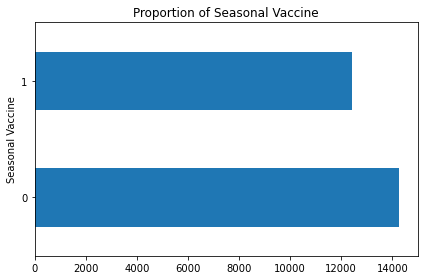

In [6]:
# small bar graph comparing who recieved the vaccine and who didn't
fig, ax = plt.subplots()
labels['seasonal_vaccine'].value_counts().plot.barh(title="Proportion of Seasonal Vaccine")
ax.set_ylabel("Seasonal Vaccine")
fig.tight_layout()

From the above graph, we can see our dependant variable (`labels`) is pretty evenly split. 

In [7]:
print("Percentage of People Vaccinated (0 = no, 1 = yes)")
(labels['seasonal_vaccine'].value_counts(normalize = True)*100)

Percentage of People Vaccinated (0 = no, 1 = yes)


0    53.439173
1    46.560827
Name: seasonal_vaccine, dtype: float64

So around 47% of respondants were vaccinated, and around 53% were not.

#### Description of Features

In [8]:
# Looking into the `features` DataFrame
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

Descriptions of the features (taken from [here](https://www.drivendata.org/competitions/66/flu-shot-learning/page/211/)): 

For all binary variables: 0 = No; 1 = Yes.

- h1n1_concern - Level of concern about the H1N1 flu. 0 = Not at all concerned; 1 = Not very concerned; 2 = Somewhat concerned; 3 = Very concerned.
- h1n1_knowledge - Level of knowledge about H1N1 flu. 0 = No knowledge; 1 = A little knowledge; 2 = A lot of knowledge.
- behavioral_antiviral_meds - Has taken antiviral medications. (binary)
- behavioral_avoidance - Has avoided close contact with others with flu-like symptoms. (binary)
- behavioral_face_mask - Has bought a face mask. (binary)
- behavioral_wash_hands - Has frequently washed hands or used hand sanitizer. (binary)
- behavioral_large_gatherings - Has reduced time at large gatherings. (binary)
- behavioral_outside_home - Has reduced contact with people outside of own household. (binary)
- behavioral_touch_face - Has avoided touching eyes, nose, or mouth. (binary)
- doctor_recc_h1n1 - H1N1 flu vaccine was recommended by doctor. (binary)
- doctor_recc_seasonal - Seasonal flu vaccine was recommended by doctor. (binary)
- chronic_med_condition - Has any of the following chronic medical conditions: asthma or an other lung condition, diabetes, a heart condition, a kidney condition, sickle cell anemia or other anemia, a neurological or neuromuscular condition, a liver condition, or a weakened immune system caused by a chronic illness or by medicines taken for a chronic illness. (binary)
- child_under_6_months - Has regular close contact with a child under the age of six months. (binary)
- health_worker - Is a healthcare worker. (binary)
- health_insurance - Has health insurance. (binary)
- opinion_h1n1_vacc_effective - Respondent's opinion about H1N1 vaccine effectiveness. 1 = Not at all effective; 2 = Not very effective; 3 = Don't know; 4 = Somewhat effective; 5 = Very effective.
- opinion_h1n1_risk - Respondent's opinion about risk of getting sick with H1N1 flu without vaccine.1 = Very Low; 2 = Somewhat low; 3 = Don't know; 4 = Somewhat high; 5 = Very high.
- opinion_h1n1_sick_from_vacc - Respondent's worry of getting sick from taking H1N1 vaccine.1 = Not at all worried; 2 = Not very worried; 3 = Don't know; 4 = Somewhat worried; 5 = Very worried.
- opinion_seas_vacc_effective - Respondent's opinion about seasonal flu vaccine effectiveness.1 = Not at all effective; 2 = Not very effective; 3 = Don't know; 4 = Somewhat effective; 5 = Very effective.
- opinion_seas_risk - Respondent's opinion about risk of getting sick with seasonal flu without vaccine.1 = Very Low; 2 = Somewhat low; 3 = Don't know; 4 = Somewhat high; 5 = Very high.
- opinion_seas_sick_from_vacc - Respondent's worry of getting sick from taking seasonal flu vaccine.1 = Not at all worried; 2 = Not very worried; 3 = Don't know; 4 = Somewhat worried; 5 = Very worried.
- age_group - Age group of respondent.
- education - Self-reported education level.
- race - Race of respondent.
- sex - Sex of respondent.
- income_poverty - Household annual income of respondent with respect to 2008 Census poverty thresholds.
- marital_status - Marital status of respondent.
- rent_or_own - Housing situation of respondent.
- employment_status - Employment status of respondent.
- hhs_geo_region - Respondent's residence using a 10-region geographic classification defined by the U.S. Dept. of Health and Human Services. Values are represented as short random character strings.
- census_msa - Respondent's residence within metropolitan statistical areas (MSA) as defined by the U.S. Census.
- household_adults - Number of other adults in household, top-coded to 3.
- household_children - Number of children in household, top-coded to 3.
- employment_industry - Type of industry respondent is employed in. Values are represented as short random character strings.
- employment_occupation - Type of occupation of respondent. Values are represented as short random character strings.

### Data: Initial Cleaning

Let's remove all of the columns related to only the H1N1 vaccine: h1n1_concern, h1n1_knowledge, doctor_recc_h1n1, opinion_h1n1_vacc_effective, opinion_h1n1_risk, opinion_h1n1_sick_from_vacc

Additionally, there are some columns where the information has been scrambled (presumably to protect the respondents personal information) so lets remove those as well as we can't extract any useful information without knowing what they are coded for: hhs_geo_region, employment_industry, employment_occupation

Finally, let's remove 'h1n1_vaccine' and 'respondent_id' from the labels DataFrame, and then turn the labels dataframe into an array so we can use it when we build our models later on. 

In [9]:
features.drop(['respondent_id', 'h1n1_concern', 'h1n1_knowledge', 'doctor_recc_h1n1',
               'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 
               'opinion_h1n1_sick_from_vacc', 'hhs_geo_region', 
               'employment_industry', 'employment_occupation'],
              axis = 1, inplace = True)

labels.drop(['h1n1_vaccine', 'respondent_id'], axis = 1, inplace= True)
labels = np.ravel(labels, order = 'C')

In [10]:
# train_test_split - creating training, validation, and test sets of data to work with 
X_train, X_test, y_train, y_test = train_test_split(features, labels,test_size=0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

## Creating Preprocessing Pipeline

In order to create a pipeline for preprocessing, let's first figure out how we will handle our missing values.

In [11]:
features.isnull().sum()

behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
marital_status                  1408
rent_or_own                     2042
employment_status               1463
census_msa                         0
household_adults                 249
household_children               249
dtype: int64

The largest amount of missing data is in `health_insurance` - let's look into the signifigance of that variable to see if we can drop it. 

In [12]:
cross_tab = pd.crosstab(features['health_insurance'], labels, margins = True)
print(cross_tab)
chi2, p, dof, expected = chi2_contingency(cross_tab)
print(chi2, p)

col_0                0     1    All
health_insurance                   
0.0               1338   398   1736
1.0               5866  6831  12697
All               7204  7229  14433
582.2867466798792 1.0559310374176207e-124


We see above a statistically significant p-value and a very high chi2 value. As such, I've decided to keep this feature. 

I've chosen to change all NaN's to 0, as in 2009 when the data was collected the Affordable Care Act had not been passed, so people were not required to have health insurance. I think that keeping the NaN's as 0's is better reflective of this time. 

As for the rest of the missing variables:

 - For the rest of the **binary data** let's also replace all of the missing data with 0's. 
 
 - For the opinion questions and family features (`household_adults` and `household_children`) which are numeric **ordinal and interval data** let's replace all the missing data with the median. Additionally, we will use `MinMaxScaler` to scale this data. Most of our data is binary, and `MinMaxScaler` will keep the scaled data in the range of 0-1, which is ideal in this case. 
 
 - Finally, for our **categorical data** let's use `OneHotEncoder` to create dummy categories
 
 We will put all of this into a pipeline, so we can test out different models!  


In [13]:
#create functions for preprocessing

# function to replace NaN's in the ordinal and interval data 
def replace_NAN_median(X_df):
    opinions = ['opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults',
                'household_children']
    for column in opinions:
        X_df[column].replace(np.nan, X_df[column].median(), inplace = True)
    return X_df

# function to replace NaN's in the catagorical data     
def replace_NAN_mode(X_df):
    miss_cat_features = ['education', 'income_poverty', 'marital_status', 'rent_or_own', 'employment_status']
    for column in miss_cat_features:
        X_df[column].replace(np.nan, statistics.mode(X_df[column]), inplace = True)
    return X_df

# function to replace NaN's in the binary data                                
def replace_NAN_0(X_df):
    miss_binary = ['behavioral_antiviral_meds', 'behavioral_avoidance','behavioral_face_mask' ,
    'behavioral_wash_hands', 'behavioral_large_gatherings', 'behavioral_outside_home',
    'behavioral_touch_face', 'doctor_recc_seasonal', 'chronic_med_condition', 
    'child_under_6_months', 'health_worker','health_insurance']
    for column in miss_binary:
        X_df[column].replace(np.nan, 0, inplace = True)
    return X_df

In [14]:
# Instantiate transformers
NAN_median = FunctionTransformer(replace_NAN_median)
NAN_mode = FunctionTransformer(replace_NAN_mode)
NAN_0 = FunctionTransformer(replace_NAN_0)
col_transformer = ColumnTransformer(transformers= [
    ("scaler", MinMaxScaler(), ['opinion_seas_vacc_effective', 'opinion_seas_risk',
                                'opinion_seas_sick_from_vacc', 
                                'household_adults', 'household_children']),
     
     # OHE catagorical string data
    ("ohe", OneHotEncoder(sparse = False, drop = "first"), ['age_group','education', 'race', 'sex', 
                                'income_poverty', 'marital_status', 'rent_or_own',
                                'employment_status', 'census_msa'])],
    verbose_feature_names_out = False,
    remainder="passthrough")



In [15]:
# Preprocessing Pipeline (Yey!)
preprocessing_pipe = Pipeline(steps=[
    ("NAN_median", NAN_median), 
    ("NAN_mode", NAN_mode),
    ("NAN_0", NAN_0),
    ("col_transformer", col_transformer)
    ])

## Modeling

### Baseline DummyClassifier Model

Lets see how well we would do if our model predicted the most frequent value *every* time - models will have to preform better than this in order to claim that they contributed any meaningful information about the data. 

In [16]:
# Using our pipeline to instantiate the model
dummy_clf_pipe = Pipeline(steps=[("preprocessing_pipe", preprocessing_pipe),
                                    ("dummy_clf", DummyClassifier(strategy="most_frequent"))])

dummy_clf_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing_pipe',
                 Pipeline(steps=[('NAN_median',
                                  FunctionTransformer(func=<function replace_NAN_median at 0x000001F20CFC0280>)),
                                 ('NAN_mode',
                                  FunctionTransformer(func=<function replace_NAN_mode at 0x000001F20CFC0550>)),
                                 ('NAN_0',
                                  FunctionTransformer(func=<function replace_NAN_0 at 0x000001F20CFC0670>)),
                                 ('col_transformer',
                                  ColumnTransformer(rem...
                                                                    'opinion_seas_risk',
                                                                    'opinion_seas_sick_from_vacc',
                                                                    'household_adults',
                                                                    'household_children']),
         

In [17]:
# getting the mean accuracy of the model
print(dummy_clf_pipe.score(X_train, y_train))
print(dummy_clf_pipe.score(X_test, y_test))

0.5319228608874742
0.541183077499064


So our models will have to have an accuracy score higher than 54% in order to have any meaningful contribution. 

## Logistic Regression Model

Because our outcome data is binary, we'll try using `LogisticRegression` to model our data.

In [18]:
# Using our pipeline to instantiate the model
logreg_base_model_pipe = Pipeline(steps=[("preprocessing_pipe", preprocessing_pipe),
                                    ("log_reg", LogisticRegression(random_state = 42))])
    

In [19]:
#creating a function to fit and get a report of how each model performed
def report(model_name, X_train, y_train, X_test, y_test):
    model_name.fit(X_train, y_train) 
    print('Training Accuracy : ',
      accuracy_score(y_train,
                             model_name.predict(X_train))*100)
    print('Test Accuracy : ',
      accuracy_score(y_test,
                             model_name.predict(X_test))*100)
    pred = model_name.predict(X_train)
    print("Training data matrix:")
    print(confusion_matrix(y_train, pred))
    print("Training report matrix:")
    print(classification_report(y_train, pred))

    pred_test = model_name.predict(X_test)
    print("Test data matrix:")
    print(confusion_matrix(y_test, pred_test))
    print("Test report matrix:")
    print(classification_report(y_test, pred_test))

In [20]:
# call function to fit and report on model
report(logreg_base_model_pipe, X_train, y_train, X_test, y_test)

Training Accuracy :  77.28265618173876
Test Accuracy :  78.0980906027705
Training data matrix:
[[6884 1639]
 [2001 5499]]
Training report matrix:
              precision    recall  f1-score   support

           0       0.77      0.81      0.79      8523
           1       0.77      0.73      0.75      7500

    accuracy                           0.77     16023
   macro avg       0.77      0.77      0.77     16023
weighted avg       0.77      0.77      0.77     16023

Test data matrix:
[[2350  541]
 [ 629 1822]]
Test report matrix:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80      2891
           1       0.77      0.74      0.76      2451

    accuracy                           0.78      5342
   macro avg       0.78      0.78      0.78      5342
weighted avg       0.78      0.78      0.78      5342



### Optimized LogisticRegression() Model
In our baseline `LogisticRegression` model, we got 78% accuracy- pretty good. 

Lets see if changing the parameters `solver`, `penalty`(if we use L1 (Lasso) or L2 (Ridge), and `C` (how strong the regularization strength is with smaller values being *stronger* regularization) will improve our accuracy. 

We can check all these things at once using `GridSearchCV`

In [21]:
param_grid = {
    # default solver is `lbfgs`, but 'liblinear' is best for small datasets, and allows checks for
    # `l1` and `l2` penalties. 
    'log_reg__solver': ['liblinear'],
    # checking which penalty works best
    'log_reg__penalty': ['l1', 'l2'], 
    # regularization strength
    'log_reg__C': [0.001,0.01,0.1,1,10,100,1000]   
}

gs = GridSearchCV(estimator=logreg_base_model_pipe,
                  param_grid=param_grid,
                  cv=5)


In [22]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing_pipe',
                                        Pipeline(steps=[('NAN_median',
                                                         FunctionTransformer(func=<function replace_NAN_median at 0x000001F20CFC0280>)),
                                                        ('NAN_mode',
                                                         FunctionTransformer(func=<function replace_NAN_mode at 0x000001F20CFC0550>)),
                                                        ('NAN_0',
                                                         FunctionTransformer(func=<function replace_NAN_0 at 0x000001F20CFC0670>)),
                                                        ('col_transf...
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse=False),


In [23]:
# Finding the parameters with the best results 
gs.best_params_

{'log_reg__C': 10, 'log_reg__penalty': 'l2', 'log_reg__solver': 'liblinear'}

In [24]:
# creating a new model with the optimized parameters
logreg_optimized_pipe = Pipeline(steps=[("preprocessing_pipe", preprocessing_pipe),
                                    ("log_reg", LogisticRegression(solver = 'liblinear', random_state = 42, C = 10, penalty= 'l2'))])
    

In [49]:
# call function to fit and report on model
report(logreg_optimized_pipe, X_train, y_train, X_test, y_test)

Training Accuracy :  77.28265618173876
Test Accuracy :  78.0980906027705
Training data matrix:
[[6883 1640]
 [2000 5500]]
Training report matrix:
              precision    recall  f1-score   support

           0       0.77      0.81      0.79      8523
           1       0.77      0.73      0.75      7500

    accuracy                           0.77     16023
   macro avg       0.77      0.77      0.77     16023
weighted avg       0.77      0.77      0.77     16023

Test data matrix:
[[2351  540]
 [ 630 1821]]
Test report matrix:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80      2891
           1       0.77      0.74      0.76      2451

    accuracy                           0.78      5342
   macro avg       0.78      0.78      0.78      5342
weighted avg       0.78      0.78      0.78      5342



We got the same output as our origional LogisticRegression model, so we'll try a different type of model next to see if we can improve the score further. 

In [50]:
# code inspiration taken from: 
# https://stackoverflow.com/questions/38787612/how-to-extract-feature-importances-from-an-sklearn-pipeline
coefficients = logreg_optimized_pipe.steps[1][1].coef_

In [51]:
# https://stackoverflow.com/questions/54646709/sklearn-pipeline-get-feature-names-after-onehotencode-in-columntransformer
feature_names = list(logreg_optimized_pipe.named_steps["preprocessing_pipe"][3].get_feature_names_out())

In [53]:
# creating function so we can plot this and other model results
def plot_importance(feat_names, feat_importances, col1_name, col2_name, title):
    # creat dataframe
    df = pd.concat([pd.DataFrame(feat_names), pd.DataFrame(np.transpose(feat_importances))], axis = 1)
    # specify column names
    df.columns = [col1_name, col2_name]
    # sort by feat_importances
    df_sort1 = df.sort_values(by=col2_name, ascending=False, key = abs).head(15)
    df_sorted = df_sort1.sort_values(by=col2_name, ascending=True, key = abs)
    
    # plot bar chart
    plt.figure(figsize=(8,8))
    plt.barh(df_sorted[col1_name], df_sorted[col2_name], align='center', color = "dodgerblue")
    plt.yticks(np.arange(len(df_sorted[col1_name])), df_sorted[col1_name]) 
    plt.xlabel(col2_name)
    plt.ylabel(col1_name)
    plt.title(title);

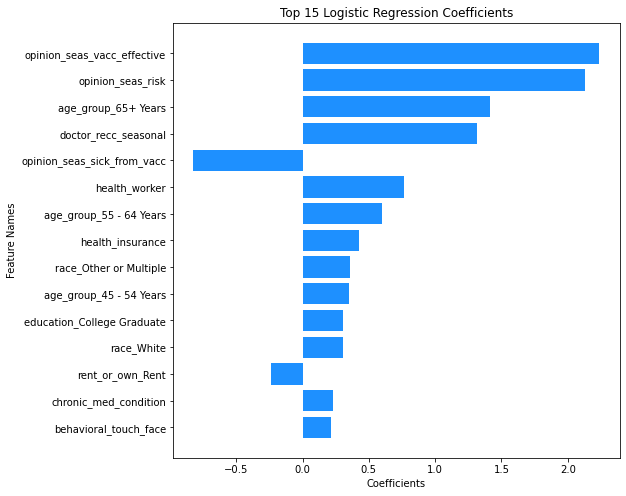

In [54]:
plot_importance(feature_names, coefficients, "Feature Names", "Coefficients",
               "Top 15 Logistic Regression Coefficients")

In [55]:
# call function to fit and report on model
report(logreg_optimized_pipe, X_train, y_train, X_test, y_test)

Training Accuracy :  77.28265618173876
Test Accuracy :  78.0980906027705
Training data matrix:
[[6883 1640]
 [2000 5500]]
Training report matrix:
              precision    recall  f1-score   support

           0       0.77      0.81      0.79      8523
           1       0.77      0.73      0.75      7500

    accuracy                           0.77     16023
   macro avg       0.77      0.77      0.77     16023
weighted avg       0.77      0.77      0.77     16023

Test data matrix:
[[2351  540]
 [ 630 1821]]
Test report matrix:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80      2891
           1       0.77      0.74      0.76      2451

    accuracy                           0.78      5342
   macro avg       0.78      0.78      0.78      5342
weighted avg       0.78      0.78      0.78      5342



### Random Forest Models

Lets use a `RandomForestClassifier`, which uses an initial weakly fitted model and then build on that to prevent overfitting, and then play around with it's parameters.

In [56]:
# create baseline `RandomForestClassifier`(base_rf)
base_rfc_pipe = Pipeline(steps=[("preprocessing_pipe", preprocessing_pipe),
                                    ("base_rf", RandomForestClassifier(random_state = 42))])

In [59]:
# call function to fit and report on model
report(base_rfc_pipe, X_train, y_train, X_test, y_test)

Training Accuracy :  99.83773325844099
Test Accuracy :  76.8251591164358
Training data matrix:
[[8510   13]
 [  13 7487]]
Training report matrix:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8523
           1       1.00      1.00      1.00      7500

    accuracy                           1.00     16023
   macro avg       1.00      1.00      1.00     16023
weighted avg       1.00      1.00      1.00     16023

Test data matrix:
[[2310  581]
 [ 657 1794]]
Test report matrix:
              precision    recall  f1-score   support

           0       0.78      0.80      0.79      2891
           1       0.76      0.73      0.74      2451

    accuracy                           0.77      5342
   macro avg       0.77      0.77      0.77      5342
weighted avg       0.77      0.77      0.77      5342



Once again, our classifier seems to have overfit, and does worse on the test data then we saw in the logistic regression. Let's limit the `max_depth` to prevent overfitting.

In [35]:
# create baseline first RandomForestClassifier iteration(itr1_rfc)
itr1_rfc_pipe = Pipeline(steps=[("preprocessing_pipe", preprocessing_pipe),
                                    ("itr1_rf", RandomForestClassifier(max_depth = 6, random_state = 42))])
itr1_rfc_pipe.fit(X_train, y_train)

print('Training Accuracy : ',
      accuracy_score(y_train,
                             itr1_rfc_pipe.predict(X_train))*100)
print('Test Accuracy : ',
      accuracy_score(y_test,
                             itr1_rfc_pipe.predict(X_test))*100)

Training Accuracy :  77.29513823878175
Test Accuracy :  77.0685136652939


That's really improved our overfitting problem - let's take a look at `n_estimators` next. 

In [36]:
# create a second RandomForestClassifier iteration(itr2_rfc)
itr2_rfc_pipe = Pipeline(steps=[("preprocessing_pipe", preprocessing_pipe),
                                    ("itr2_rf", RandomForestClassifier(max_depth = 6,
                                                                       n_estimators = 90,
                                                                       random_state = 42))])
itr2_rfc_pipe.fit(X_train, y_train)

print('Training Accuracy : ',
      accuracy_score(y_train,
                             itr2_rfc_pipe.predict(X_train))*100)
print('Test Accuracy : ',
      accuracy_score(y_test,
                             itr2_rfc_pipe.predict(X_test))*100)

Training Accuracy :  77.28889721026026
Test Accuracy :  77.0497940846125


Changing `n_estimators` doesn't seem to have had any huge effect. Now we'll try adjusting `max_leaf_nodes`and see if that improves our accuracy by limiting the number of nodes allowed in the model.

In [37]:
# create a third RandomForestClassifier iteration(itr3_rfc)
itr3_rfc_pipe = Pipeline(steps=[("preprocessing_pipe", preprocessing_pipe),
                                    ("itr3_rf", RandomForestClassifier(max_depth = 6,
                                                                       max_leaf_nodes = 100,
                                                                       random_state = 42))])
itr3_rfc_pipe.fit(X_train, y_train)

print('Training Accuracy : ',
      accuracy_score(y_train,
                             itr3_rfc_pipe.predict(X_train))*100)
print('Test Accuracy : ',
      accuracy_score(y_test,
                             itr3_rfc_pipe.predict(X_test))*100)

Training Accuracy :  77.31386132434625
Test Accuracy :  77.311868214152


Finally, lets define the minimum number of observations in any given node needed for the model to split it using `min_sample_split` and see if that improves our test accuracy.

In [38]:
# create a fourth RandomForestClassifier iteration(itr4_rfc)
itr4_rfc_pipe = Pipeline(steps=[("preprocessing_pipe", preprocessing_pipe),
                                    ("itr4_rf", RandomForestClassifier(max_depth = 6,
                                                                       max_leaf_nodes = 100,
                                                                       min_samples_split = 4,
                                                                       random_state = 42))])
itr4_rfc_pipe.fit(X_train, y_train)

print('Training Accuracy : ',
      accuracy_score(y_train,

                     itr4_rfc_pipe.predict(X_train))*100)
print('Test Accuracy : ',
      accuracy_score(y_test,
                             itr4_rfc_pipe.predict(X_test))*100)

Training Accuracy :  77.26393309617426
Test Accuracy :  77.33058779483339


This resulted in the highest accuracy so far on our test data, so we will stick with this model and it's hyperparameters. 

In [39]:
rfc_feature_import = itr4_rfc_pipe.named_steps["itr4_rf"].feature_importances_

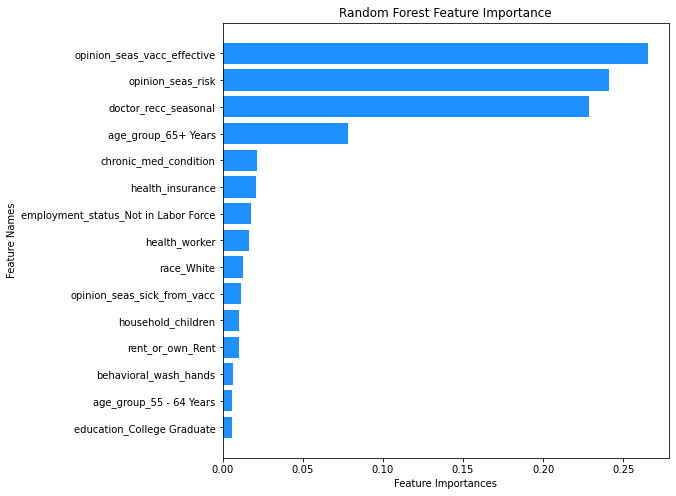

In [40]:
#plot the data
plot_importance(feature_names, rfc_feature_import, "Feature Names", "Feature Importances", 
               "Random Forest Feature Importance")

### XGBoost Model

So far, we've been hovering around 77- 78% for accuracy - lets see if we can improve that by using an XGBoost model. XGBoost is provides some of the best-in-class performance compared to other classification algorithms, so I figured it was worth checking it out here. 

In [41]:
# create baseline XGB model pipeline
base_XGB_pipe = Pipeline(steps=[("preprocessing_pipe", preprocessing_pipe),
                               ("base_XGB", XGBClassifier(random_state=42,
                                                         use_label_encoder=False))])
# fit to pipeline
base_XGB_pipe.fit(X_train, y_train)

train_pred = base_XGB_pipe.predict(X_train)
test_pred = base_XGB_pipe.predict(X_test)

#find accuracy of test and training sets
training_accuracy = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, test_pred)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Test accuracy: {:.4}%'.format(test_accuracy * 100))


[16:51:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy: 87.82%
Test accuracy: 76.26%


So the test set is still preforming around whaty we've seen in the earlier models, and our model seems a bit overfit to our data - lets try using `GridSearchCV` to find paramenters that will work better. 

In [42]:
# creating the parameters grid
param_grid = {
    'base_XGB__learning_rate': [0.1, 0.2],
    'base_XGB__max_depth': [3, 4],
    'base_XGB__min_child_weight': [2, 3],
    'base_XGB__subsample': [0.6, 0.7],
    'base_XGB__n_estimators': [75, 80],
}

In [43]:
#perform GridSearchCV
grid_XGB = GridSearchCV(estimator=base_XGB_pipe,
                        scoring = "accuracy",
                        param_grid=param_grid,
                        cv=5)
grid_XGB.fit(X_train, y_train)

[16:51:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:51:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:51:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:51:45] WARNING:

[16:52:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:52:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:52:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:52:04] WARNING:

[16:52:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:52:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:52:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:52:26] WARNING:

[16:52:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:52:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:52:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:52:48] WARNING:

[16:53:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:53:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:53:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:53:08] WARNING:

[16:53:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:53:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:53:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:53:28] WARNING:

[16:53:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:53:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:53:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:53:50] WARNING:

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing_pipe',
                                        Pipeline(steps=[('NAN_median',
                                                         FunctionTransformer(func=<function replace_NAN_median at 0x000001F20CFC0280>)),
                                                        ('NAN_mode',
                                                         FunctionTransformer(func=<function replace_NAN_mode at 0x000001F20CFC0550>)),
                                                        ('NAN_0',
                                                         FunctionTransformer(func=<function replace_NAN_0 at 0x000001F20CFC0670>)),
                                                        ('col_transf...
                                                      random_state=42,
                                                      reg_alpha=0, reg_lambda=1,
                                                      scale_pos_weight=1,
           

In [44]:
grid_XGB.best_params_

{'base_XGB__learning_rate': 0.2,
 'base_XGB__max_depth': 3,
 'base_XGB__min_child_weight': 3,
 'base_XGB__n_estimators': 75,
 'base_XGB__subsample': 0.7}

In [45]:
training_preds = grid_XGB.predict(X_train)
test_preds = grid_XGB.predict(X_test)

training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Test accuracy: {:.4}%'.format(test_accuracy * 100))


Training Accuracy: 78.63%
Test accuracy: 78.83%


In [46]:
#get feature importances
optimized_XGB_pipe = Pipeline(steps=[("preprocessing_pipe", preprocessing_pipe),
                      ("optimized_XGB", XGBClassifier(random_state=42,
                                                      use_label_encoder=False,
                                                      learning_rate =  0.1,
                                                      max_depth = 4,
                                                      min_child_weight = 3,
                                                      n_estimators = 75,
                                                      subsample = 0.7))])
optimized_XGB_pipe.fit(X_train, y_train)

# https://9to5answer.com/feature-importance-with-xgbclassifier
xgb_fea_imp=pd.DataFrame(list(optimized_XGB_pipe[1].get_booster().get_fscore().items()))
#https://stackoverflow.com/questions/54933804/how-to-restore-the-original-feature-names-in-xgboost-feature-importance-plot-af

[16:53:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


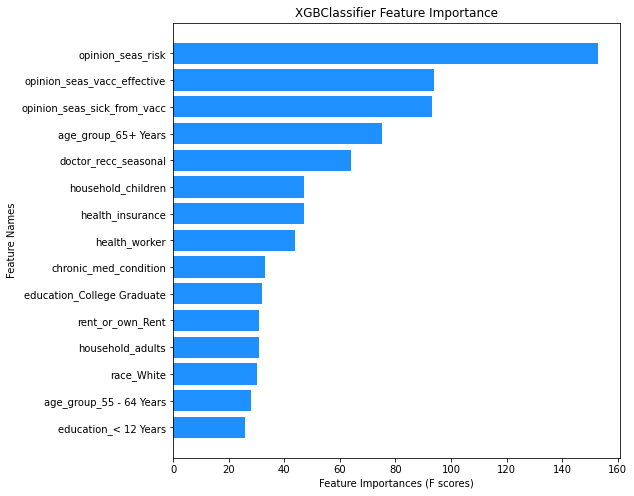

In [47]:
plot_importance(feature_names, xgb_fea_imp[1], "Feature Names", "Feature Importances (F scores)", 
                "XGBClassifier Feature Importance")

As this is our best performing model, lets check how our model performs on our validation set. 

In [48]:
optimized_XGB_pipe.fit(X_train, y_train)

val_preds = optimized_XGB_pipe.predict(X_val)

val_accuracy = accuracy_score(y_val, val_preds)

print('Final model validation accuracy: {:.4}%'.format(val_accuracy * 100))

[16:53:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Final model validation accuracy: 78.29%


## Conclusions

- 